In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
from matplotlib import pyplot as plt # type: ignore
import os

In [2]:
data2 = pd.read_csv('..\..\Dataset\casos_mensais.csv', delimiter=',')

In [3]:
data2

,dt_notificacao,nm_municipio,casos
0,2013-12-01,Adamantina,0
1,2013-12-01,Adolfo,0
2,2013-12-01,Aguaí,0
3,2013-12-01,Águas da Prata,0
4,2013-12-01,Águas de Lindóia,0
...,...,...,...
83845,2024-09-01,Vista Alegre do Alto,1
83846,2024-09-01,Vitória Brasil,0
83847,2024-09-01,Votorantim,3
83848,2024-09-01,Votuporanga,144


In [4]:
#le o dataset de controle de trafego na Web em LA, pegando apenas 3 colunas especificas do arquivo e converte a colunas de "Date" para formato apropriado
data = pd.read_csv(os.path.join('..\..\Dataset\casos_mensais.csv'), delimiter=',',
                   parse_dates=['dt_notificacao']).loc[:, ['dt_notificacao', 'nm_municipio', 'casos']]

#dados organizados de acordo com a data e tipo de dispositivo e soma os valores da coluna Sessions
#data = data.groupby(['DT_NOTIFICACAO', 'NM_MUNICIPIO'], as_index=False)['REGISTROS'].mean()

#cria nova tabela contendo datas que não tiveram sessoes para o dispositivo tablet, adicionando manualmente os valores 0 para corrigir as informações faltantes
#fixes = pd.DataFrame({'Date': pd.to_datetime(['2016-12-01', '2018-10-13']), 
 #                     'Device Category': ['tablet', 'tablet'] ,
  #                    'Sessions': [np.nan, np.nan]})

# junta os dados corrigidos à tabela  original concatenando as linhas e garantindo que os itens foram reorganizados, ignorando os indices antigos
#data = pd.concat([data, fixes], axis=0, ignore_index=True)

In [5]:
data.head(50)


,dt_notificacao,nm_municipio,casos
0,2013-12-01,Adamantina,0
1,2013-12-01,Adolfo,0
2,2013-12-01,Aguaí,0
3,2013-12-01,Águas da Prata,0
4,2013-12-01,Águas de Lindóia,0
5,2013-12-01,Águas de Santa Bárbara,0
6,2013-12-01,Águas de São Pedro,0
7,2013-12-01,Agudos,0
8,2013-12-01,Alambari,0
9,2013-12-01,Alfredo Marcondes,0


Divisão dos dados em treino e validação

In [6]:
#intervalo de dados de treino
train = pd.DataFrame(data)
#intervalo de dados de validação
valid = pd.DataFrame(data)
#conta quantos dias distintos tem no conjunto de validação 
# h é a quantidade timestamps(pontos especificos na linha do tempo) que se quer prever no futuro
h = valid['dt_notificacao'].nunique()

In [7]:
#importação da biblioteca utilizada para criar e manipular series temporais
from darts import TimeSeries # type: ignore
#retorna uma lista de todos os dispositivos únicos, para saber quantas series temporais criar
series_names = train['nm_municipio'].unique()
#cria uma serie temporal a partir de um dataframe. 
# Cada série temporal representa a evolução de um valor ao longo do tempo para um grupo específico (neste caso, um tipo de dispositivo)
train_series = TimeSeries.from_group_dataframe(train, time_col='dt_notificacao', value_cols=['casos'], group_cols=['nm_municipio'], freq='D', fill_missing_dates=True, fillna_value=0.)

In [8]:
from darts.models import KalmanForecaster # type: ignore


C:\Users\kenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Predictions list to store results
preds = list()

# Iterate over each series in train_series
for i, series in enumerate(train_series):
    try:
        print("epoch:", i)

        # Initialize KalmanForecaster with dim_x=1
        model = KalmanForecaster(dim_x=130)

        # Fit the model on the current time series
        model.fit(series=series)

        # Predict future values (h steps ahead)
        p = model.predict(h).pd_dataframe()

        # Keep original date index
        p = p.set_index(series.time_index[-h:])  # Align predictions with the last h dates of series

        # Add the 'nm_municipio' column
        p['nm_municipio'] = series_names[i]

        # Append predictions to list
        preds.append(p)

    except Exception as exp:
        print(f"Error at epoch {i}: {exp}")

# Concatenate predictions and rename 'casos' to 'Predicted'
preds = pd.concat(preds, axis=0, ignore_index=False).rename(columns={'casos': 'Predicted'})

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15


KeyboardInterrupt: 

In [188]:
save_preds = preds #.where([preds['casos']] != None)

In [189]:
#junta os dados r5eais com os dados previstos
preds = preds.merge(train, on=['dt_notificacao', 'nm_municipio'], how='inner')
    
    
#usa o MAPE para medir o quao distantes estao os valores dos reais
from sklearn.metrics import mean_absolute_percentage_error # type: ignore
mean_absolute_percentage_error(preds['casos'], preds['Predicted'])

0.786046511627907

In [169]:
valid['dt_notificacao'].unique()

<DatetimeArray>
['2019-01-01 00:00:00', '2019-02-01 00:00:00', '2019-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]

In [198]:
preds

,dt_notificacao,Predicted,nm_municipio,casos
0,2024-05-01,0.0,Adamantina,23
1,2024-06-01,0.0,Adamantina,11
2,2024-07-01,0.0,Adamantina,4
3,2024-08-01,0.0,Adamantina,16
4,2024-09-01,0.0,Adamantina,5
...,...,...,...,...
3220,2024-05-01,0.0,Zacarias,1
3221,2024-06-01,0.0,Zacarias,2
3222,2024-07-01,0.0,Zacarias,0
3223,2024-08-01,0.0,Zacarias,0


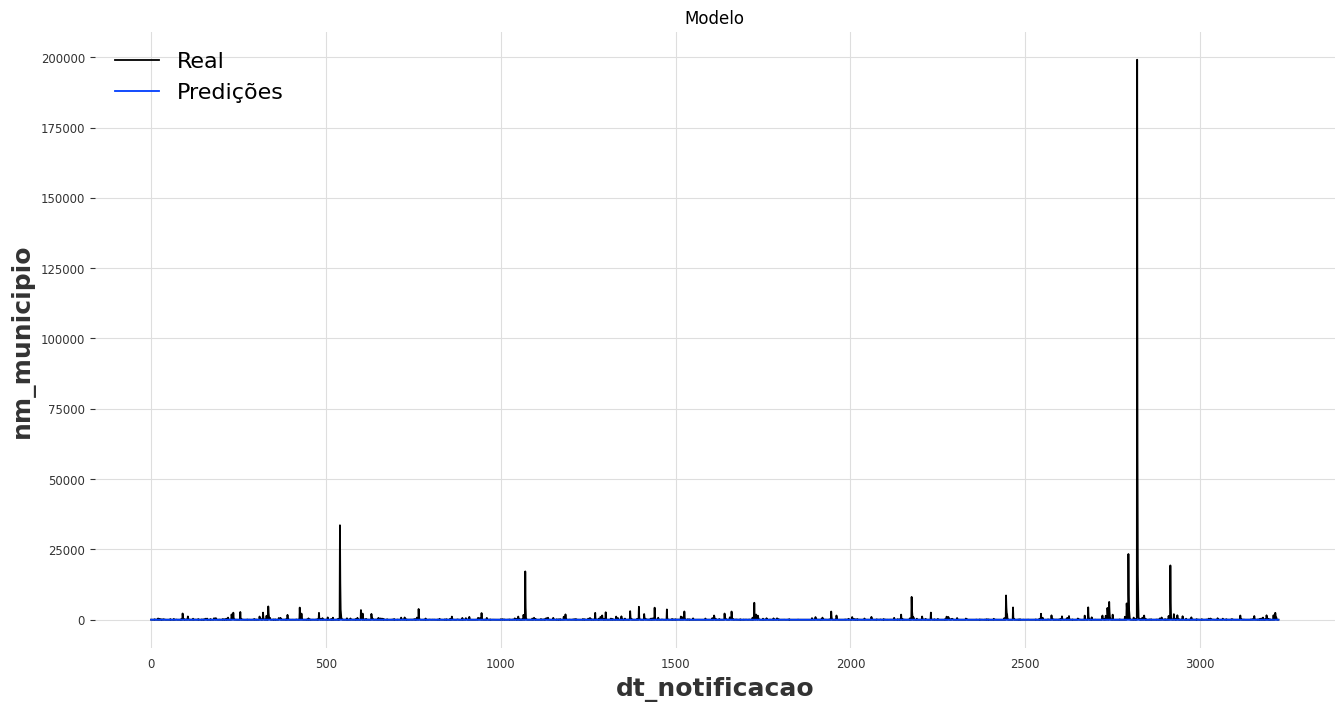

In [202]:
plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('dt_notificacao', fontsize = 18)
plt.ylabel("nm_municipio", fontsize = 18)
plt.plot(preds[['casos']])
plt.plot(preds[['Predicted']])
plt.legend(['Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [50]:
from darts.models import KalmanForecaster

preds = list()
for i, series in enumerate(train_series):
    model = KalmanForecaster(dim_x=100)
    model.fit(series=series)
    p = model.predict(h, num_samples=100)
    p = [p.quantile_df(q) for q in [0.05, 0.5, 0.95]]
    p = pd.concat(p, axis=1).reset_index()
    p['Device Category'] = series_names[i]
    preds.append(p)
preds = pd.concat(preds, axis=0, ignore_index=True)
preds = preds.merge(valid, on=['Date', 'Device Category'], how='left')

C:\Users\asawoi\AppData\Local\Temp\ipykernel_28396\4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
C:\Users\asawoi\AppData\Local\Temp\ipykernel_28396\4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
C:\Users\asawoi\AppData\Local\Temp\ipykernel_28396\4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

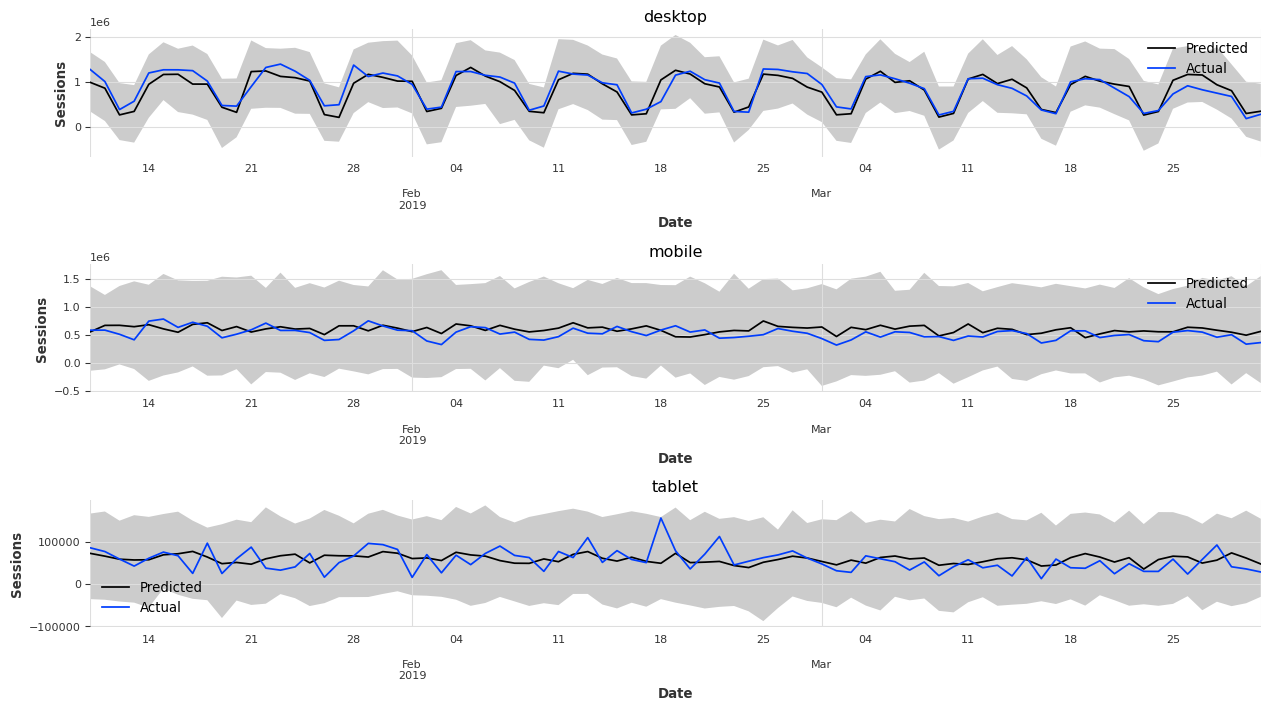

In [51]:
fig,ax = plt.subplots(3,1,figsize=(1280/96, 720/96), dpi=96)
preds_ = preds[preds['Date'] >= '2019-01-10']
for ax_, device in enumerate(preds_['Device Category'].unique()):
    p_ = preds_.loc[preds_['Device Category'] == device]
    p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
    ax[ax_].fill_between(p_['Date'], p_['Sessions_0.05'], p_['Sessions_0.95'], alpha=0.2)
    p_.plot(x='Date', y=['Predicted', 'Actual'], ax=ax[ax_], title=device)
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sessions')
fig.tight_layout()

In [52]:
from sklearn.metrics import mean_pinball_loss
for q in [0.05, 0.5, 0.95]:
    print(f'Pinball loss at {q}: {mean_pinball_loss(preds["Sessions"], preds[f"Sessions_{q}"])}')

Pinball loss at 0.05: 268637.8143807489
Pinball loss at 0.5: 51956.13305713162
Pinball loss at 0.95: 271511.7489896879
